# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:10, 18.0MB/s]                              
SVHN Testing Set: 64.3MB [00:04, 15.6MB/s]                            


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

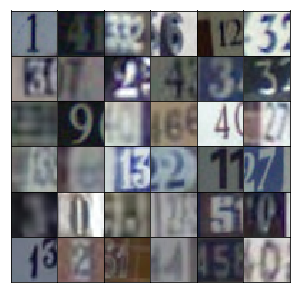

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [20]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [21]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [22]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [24]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [25]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [26]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [27]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: 1.3509... Generator Loss: 0.5947
Epoch 1/25... Discriminator Loss: 0.3573... Generator Loss: 2.0293
Epoch 1/25... Discriminator Loss: 0.3394... Generator Loss: 1.5613
Epoch 1/25... Discriminator Loss: 0.1641... Generator Loss: 2.5189
Epoch 1/25... Discriminator Loss: 0.1805... Generator Loss: 2.5385
Epoch 1/25... Discriminator Loss: 0.0988... Generator Loss: 3.0503
Epoch 1/25... Discriminator Loss: 0.1246... Generator Loss: 2.7359
Epoch 1/25... Discriminator Loss: 0.2306... Generator Loss: 2.5891
Epoch 1/25... Discriminator Loss: 1.1697... Generator Loss: 1.6264
Epoch 1/25... Discriminator Loss: 0.8656... Generator Loss: 1.9259


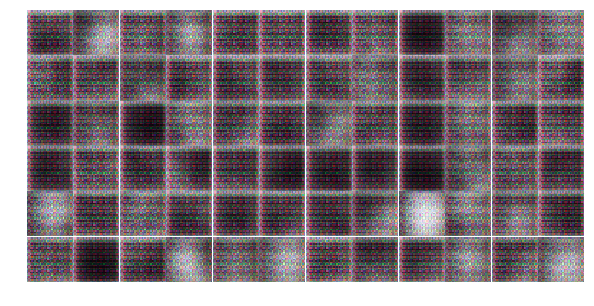

Epoch 1/25... Discriminator Loss: 0.6097... Generator Loss: 1.3948
Epoch 1/25... Discriminator Loss: 0.3563... Generator Loss: 1.9641
Epoch 1/25... Discriminator Loss: 0.6749... Generator Loss: 0.9390
Epoch 1/25... Discriminator Loss: 0.3346... Generator Loss: 2.1284
Epoch 1/25... Discriminator Loss: 0.6340... Generator Loss: 1.1758
Epoch 1/25... Discriminator Loss: 0.6590... Generator Loss: 1.0053
Epoch 1/25... Discriminator Loss: 0.1917... Generator Loss: 2.2218
Epoch 1/25... Discriminator Loss: 1.8776... Generator Loss: 1.4535
Epoch 1/25... Discriminator Loss: 1.0532... Generator Loss: 2.2649
Epoch 1/25... Discriminator Loss: 0.5080... Generator Loss: 1.7557


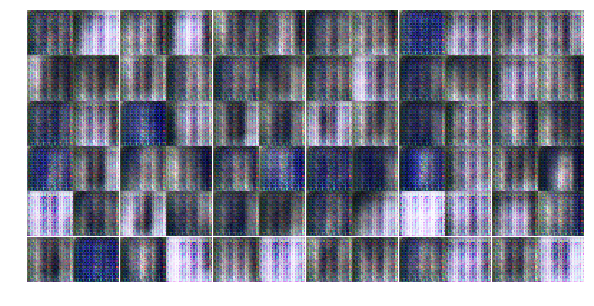

Epoch 1/25... Discriminator Loss: 0.2882... Generator Loss: 2.0008
Epoch 1/25... Discriminator Loss: 0.2833... Generator Loss: 2.5512
Epoch 1/25... Discriminator Loss: 0.0888... Generator Loss: 3.6368
Epoch 1/25... Discriminator Loss: 0.2887... Generator Loss: 1.7701
Epoch 1/25... Discriminator Loss: 1.7772... Generator Loss: 5.8866
Epoch 1/25... Discriminator Loss: 0.9881... Generator Loss: 2.4613
Epoch 1/25... Discriminator Loss: 0.3442... Generator Loss: 2.8320
Epoch 1/25... Discriminator Loss: 0.1025... Generator Loss: 4.3478
Epoch 1/25... Discriminator Loss: 0.4702... Generator Loss: 1.6253
Epoch 1/25... Discriminator Loss: 0.1788... Generator Loss: 5.8118


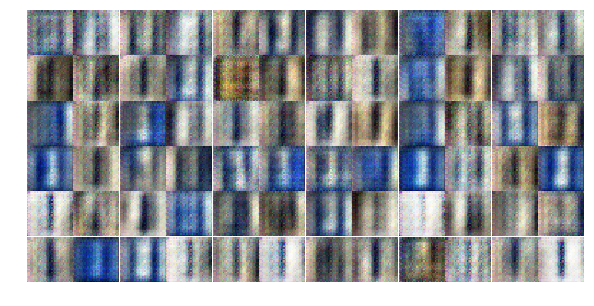

Epoch 1/25... Discriminator Loss: 0.5071... Generator Loss: 1.7024
Epoch 1/25... Discriminator Loss: 0.9504... Generator Loss: 0.8634
Epoch 1/25... Discriminator Loss: 0.2607... Generator Loss: 2.7163
Epoch 1/25... Discriminator Loss: 0.6524... Generator Loss: 1.7309
Epoch 1/25... Discriminator Loss: 0.9141... Generator Loss: 5.0158
Epoch 1/25... Discriminator Loss: 0.6928... Generator Loss: 3.5851
Epoch 1/25... Discriminator Loss: 0.8937... Generator Loss: 0.8714
Epoch 1/25... Discriminator Loss: 0.4397... Generator Loss: 1.9663
Epoch 1/25... Discriminator Loss: 0.4557... Generator Loss: 1.7823
Epoch 1/25... Discriminator Loss: 0.6216... Generator Loss: 1.6067


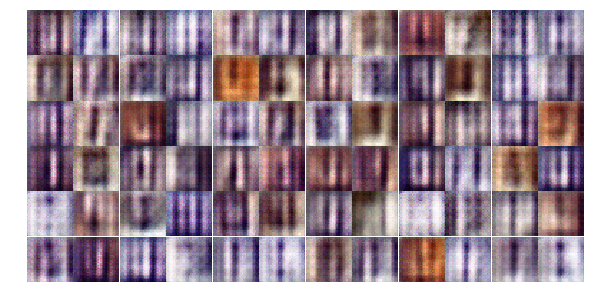

Epoch 1/25... Discriminator Loss: 0.4092... Generator Loss: 2.0314
Epoch 1/25... Discriminator Loss: 0.4202... Generator Loss: 1.6852
Epoch 1/25... Discriminator Loss: 0.2770... Generator Loss: 2.6359
Epoch 1/25... Discriminator Loss: 0.7431... Generator Loss: 1.9244
Epoch 1/25... Discriminator Loss: 0.5849... Generator Loss: 1.8691
Epoch 1/25... Discriminator Loss: 1.0835... Generator Loss: 0.7187
Epoch 1/25... Discriminator Loss: 0.4156... Generator Loss: 2.6097
Epoch 1/25... Discriminator Loss: 0.2956... Generator Loss: 2.3948
Epoch 1/25... Discriminator Loss: 0.4505... Generator Loss: 1.9269
Epoch 1/25... Discriminator Loss: 0.7142... Generator Loss: 1.6313


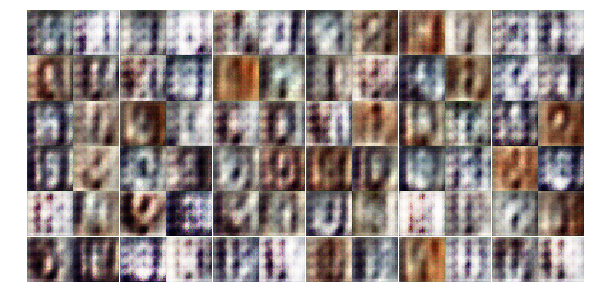

Epoch 1/25... Discriminator Loss: 0.4646... Generator Loss: 1.7950
Epoch 1/25... Discriminator Loss: 0.4621... Generator Loss: 1.8828
Epoch 1/25... Discriminator Loss: 0.3783... Generator Loss: 2.5385
Epoch 1/25... Discriminator Loss: 0.7168... Generator Loss: 1.0842
Epoch 1/25... Discriminator Loss: 0.9747... Generator Loss: 0.8946
Epoch 1/25... Discriminator Loss: 0.8429... Generator Loss: 1.2575
Epoch 1/25... Discriminator Loss: 0.6876... Generator Loss: 1.5759
Epoch 2/25... Discriminator Loss: 0.7729... Generator Loss: 1.6156
Epoch 2/25... Discriminator Loss: 0.5834... Generator Loss: 1.4413
Epoch 2/25... Discriminator Loss: 0.9406... Generator Loss: 1.3610


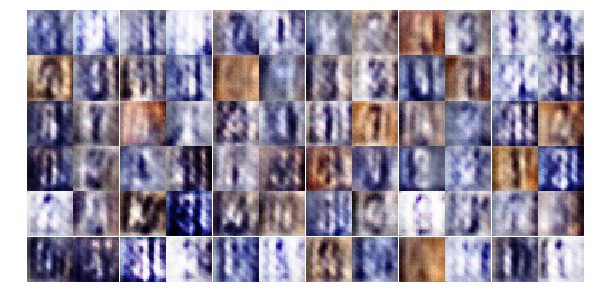

Epoch 2/25... Discriminator Loss: 0.8592... Generator Loss: 1.2687
Epoch 2/25... Discriminator Loss: 1.3162... Generator Loss: 0.5842
Epoch 2/25... Discriminator Loss: 0.8907... Generator Loss: 1.1108
Epoch 2/25... Discriminator Loss: 0.9673... Generator Loss: 1.4537
Epoch 2/25... Discriminator Loss: 0.8493... Generator Loss: 1.5390
Epoch 2/25... Discriminator Loss: 0.9847... Generator Loss: 1.1837
Epoch 2/25... Discriminator Loss: 1.2540... Generator Loss: 0.8958
Epoch 2/25... Discriminator Loss: 0.7771... Generator Loss: 1.3821
Epoch 2/25... Discriminator Loss: 0.9516... Generator Loss: 1.0686
Epoch 2/25... Discriminator Loss: 1.0040... Generator Loss: 1.1249


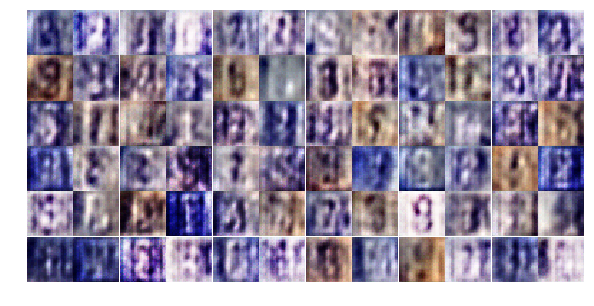

Epoch 2/25... Discriminator Loss: 0.9770... Generator Loss: 1.0988
Epoch 2/25... Discriminator Loss: 1.2442... Generator Loss: 1.6292
Epoch 2/25... Discriminator Loss: 0.9024... Generator Loss: 1.8598
Epoch 2/25... Discriminator Loss: 1.0564... Generator Loss: 1.0147
Epoch 2/25... Discriminator Loss: 1.0942... Generator Loss: 1.0777
Epoch 2/25... Discriminator Loss: 1.0328... Generator Loss: 0.9754
Epoch 2/25... Discriminator Loss: 0.8871... Generator Loss: 1.2187
Epoch 2/25... Discriminator Loss: 0.9863... Generator Loss: 1.1938
Epoch 2/25... Discriminator Loss: 1.0261... Generator Loss: 1.3100
Epoch 2/25... Discriminator Loss: 1.0377... Generator Loss: 0.9477


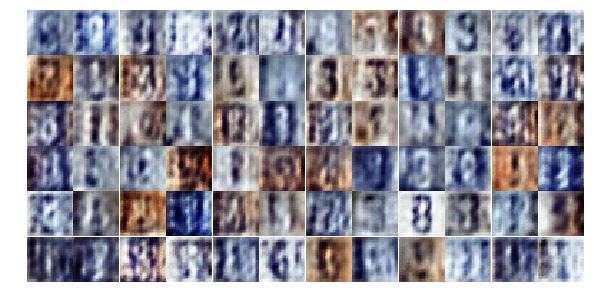

Epoch 2/25... Discriminator Loss: 0.8627... Generator Loss: 1.1501
Epoch 2/25... Discriminator Loss: 0.9866... Generator Loss: 1.4966
Epoch 2/25... Discriminator Loss: 0.7861... Generator Loss: 1.2629
Epoch 2/25... Discriminator Loss: 1.0603... Generator Loss: 0.8755
Epoch 2/25... Discriminator Loss: 0.9280... Generator Loss: 1.2483
Epoch 2/25... Discriminator Loss: 0.7427... Generator Loss: 1.3286
Epoch 2/25... Discriminator Loss: 0.7860... Generator Loss: 1.1190
Epoch 2/25... Discriminator Loss: 1.0510... Generator Loss: 0.7579
Epoch 2/25... Discriminator Loss: 1.1822... Generator Loss: 0.9644
Epoch 2/25... Discriminator Loss: 0.9415... Generator Loss: 0.9865


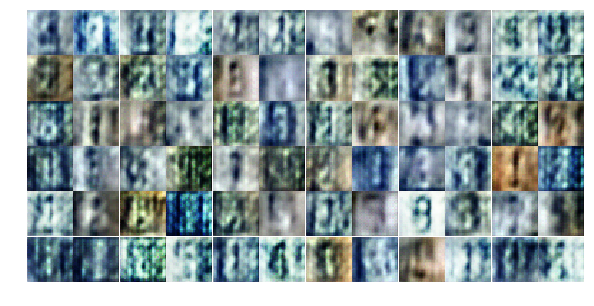

Epoch 2/25... Discriminator Loss: 1.6105... Generator Loss: 1.1944
Epoch 2/25... Discriminator Loss: 1.1454... Generator Loss: 1.0131
Epoch 2/25... Discriminator Loss: 1.0658... Generator Loss: 1.1707
Epoch 2/25... Discriminator Loss: 0.9365... Generator Loss: 0.8643
Epoch 2/25... Discriminator Loss: 1.0199... Generator Loss: 1.2449
Epoch 2/25... Discriminator Loss: 1.1028... Generator Loss: 1.1141
Epoch 2/25... Discriminator Loss: 1.0396... Generator Loss: 1.0753
Epoch 2/25... Discriminator Loss: 0.9141... Generator Loss: 1.5638
Epoch 2/25... Discriminator Loss: 1.3829... Generator Loss: 1.2929
Epoch 2/25... Discriminator Loss: 0.9951... Generator Loss: 0.9046


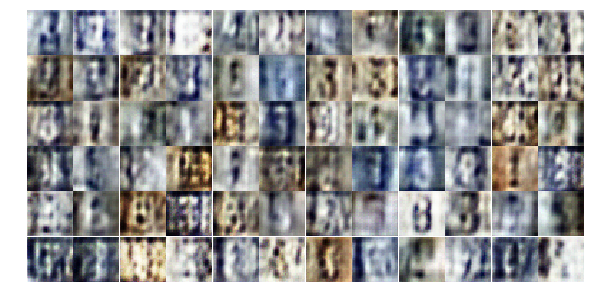

Epoch 2/25... Discriminator Loss: 0.6932... Generator Loss: 1.6101
Epoch 2/25... Discriminator Loss: 1.2182... Generator Loss: 0.6008
Epoch 2/25... Discriminator Loss: 0.8368... Generator Loss: 0.9602
Epoch 2/25... Discriminator Loss: 0.9797... Generator Loss: 0.9237
Epoch 2/25... Discriminator Loss: 1.3407... Generator Loss: 1.0255
Epoch 2/25... Discriminator Loss: 0.8777... Generator Loss: 1.0331
Epoch 2/25... Discriminator Loss: 1.0146... Generator Loss: 1.7011
Epoch 2/25... Discriminator Loss: 0.7507... Generator Loss: 1.6910
Epoch 2/25... Discriminator Loss: 0.6120... Generator Loss: 1.3685
Epoch 2/25... Discriminator Loss: 0.5954... Generator Loss: 1.4038


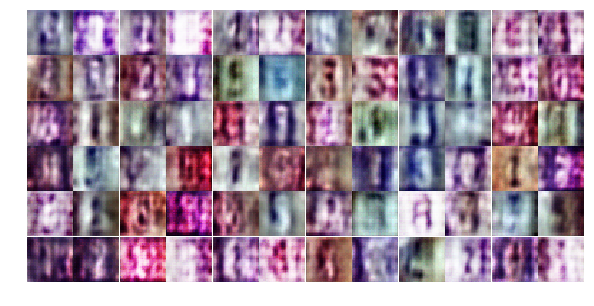

Epoch 2/25... Discriminator Loss: 0.8373... Generator Loss: 0.9606
Epoch 2/25... Discriminator Loss: 0.9140... Generator Loss: 1.0167
Epoch 2/25... Discriminator Loss: 0.9106... Generator Loss: 0.9403
Epoch 2/25... Discriminator Loss: 1.0303... Generator Loss: 0.9496
Epoch 3/25... Discriminator Loss: 0.8707... Generator Loss: 1.7605
Epoch 3/25... Discriminator Loss: 0.7592... Generator Loss: 1.2467
Epoch 3/25... Discriminator Loss: 0.8594... Generator Loss: 1.5506
Epoch 3/25... Discriminator Loss: 0.8694... Generator Loss: 0.7983
Epoch 3/25... Discriminator Loss: 1.0488... Generator Loss: 1.1072
Epoch 3/25... Discriminator Loss: 1.0452... Generator Loss: 1.1581


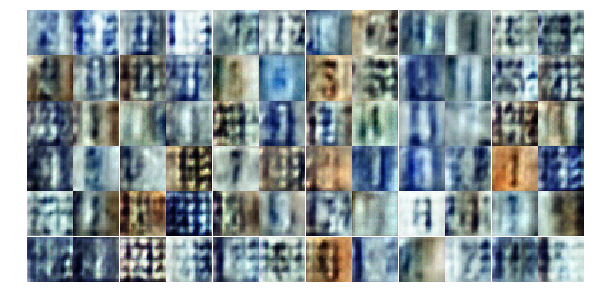

Epoch 3/25... Discriminator Loss: 0.7010... Generator Loss: 1.0932
Epoch 3/25... Discriminator Loss: 1.2852... Generator Loss: 0.6773
Epoch 3/25... Discriminator Loss: 0.7907... Generator Loss: 1.3296
Epoch 3/25... Discriminator Loss: 0.9286... Generator Loss: 0.8879
Epoch 3/25... Discriminator Loss: 0.7492... Generator Loss: 1.2159
Epoch 3/25... Discriminator Loss: 0.8754... Generator Loss: 0.9989
Epoch 3/25... Discriminator Loss: 0.6781... Generator Loss: 1.3757
Epoch 3/25... Discriminator Loss: 0.6932... Generator Loss: 2.2257
Epoch 3/25... Discriminator Loss: 0.6657... Generator Loss: 1.4049
Epoch 3/25... Discriminator Loss: 0.9343... Generator Loss: 1.6101


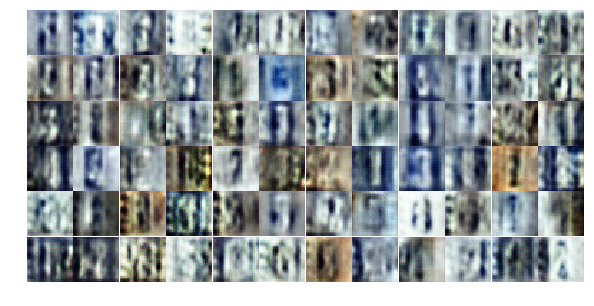

Epoch 3/25... Discriminator Loss: 0.8505... Generator Loss: 1.2782
Epoch 3/25... Discriminator Loss: 0.6311... Generator Loss: 1.4334
Epoch 3/25... Discriminator Loss: 0.8726... Generator Loss: 0.8083
Epoch 3/25... Discriminator Loss: 0.8501... Generator Loss: 1.1780
Epoch 3/25... Discriminator Loss: 1.0137... Generator Loss: 0.8752
Epoch 3/25... Discriminator Loss: 0.8938... Generator Loss: 1.2078
Epoch 3/25... Discriminator Loss: 1.0223... Generator Loss: 0.6956
Epoch 3/25... Discriminator Loss: 0.5554... Generator Loss: 1.5259
Epoch 3/25... Discriminator Loss: 0.7499... Generator Loss: 1.4394
Epoch 3/25... Discriminator Loss: 0.8652... Generator Loss: 0.9461


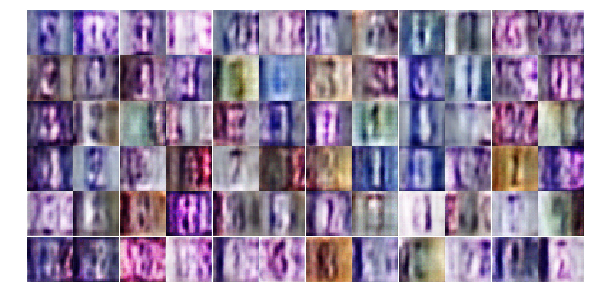

Epoch 3/25... Discriminator Loss: 0.8462... Generator Loss: 1.4052
Epoch 3/25... Discriminator Loss: 0.5863... Generator Loss: 1.3711
Epoch 3/25... Discriminator Loss: 0.8324... Generator Loss: 1.0536
Epoch 3/25... Discriminator Loss: 0.8096... Generator Loss: 1.0411
Epoch 3/25... Discriminator Loss: 0.8251... Generator Loss: 1.1182
Epoch 3/25... Discriminator Loss: 0.8553... Generator Loss: 1.2506
Epoch 3/25... Discriminator Loss: 1.6456... Generator Loss: 0.3404
Epoch 3/25... Discriminator Loss: 0.7330... Generator Loss: 1.5850
Epoch 3/25... Discriminator Loss: 0.6945... Generator Loss: 1.2843
Epoch 3/25... Discriminator Loss: 0.7807... Generator Loss: 1.2736


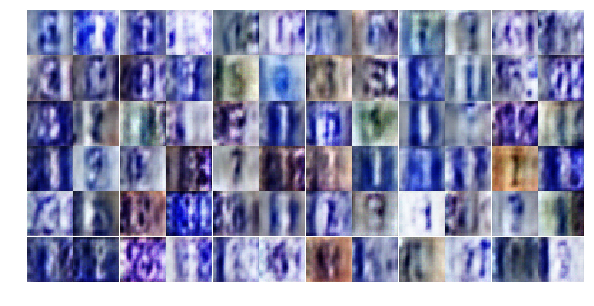

Epoch 3/25... Discriminator Loss: 0.6359... Generator Loss: 1.2377
Epoch 3/25... Discriminator Loss: 0.5894... Generator Loss: 1.5850
Epoch 3/25... Discriminator Loss: 0.4970... Generator Loss: 1.5845
Epoch 3/25... Discriminator Loss: 0.5731... Generator Loss: 2.6922
Epoch 3/25... Discriminator Loss: 0.2744... Generator Loss: 2.4060
Epoch 3/25... Discriminator Loss: 0.9520... Generator Loss: 0.8587
Epoch 3/25... Discriminator Loss: 0.6421... Generator Loss: 1.7208
Epoch 3/25... Discriminator Loss: 0.6718... Generator Loss: 1.3587
Epoch 3/25... Discriminator Loss: 0.5627... Generator Loss: 1.6498
Epoch 3/25... Discriminator Loss: 0.9924... Generator Loss: 2.6225


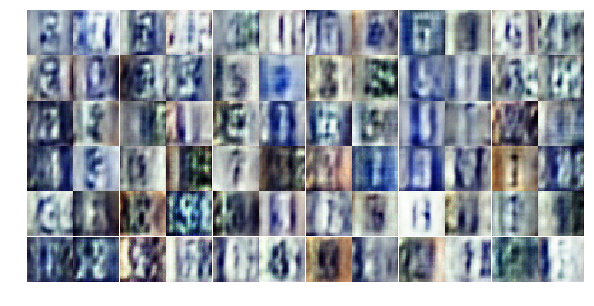

Epoch 3/25... Discriminator Loss: 0.8907... Generator Loss: 0.9827
Epoch 3/25... Discriminator Loss: 0.6894... Generator Loss: 1.1796
Epoch 3/25... Discriminator Loss: 0.7185... Generator Loss: 1.1277
Epoch 3/25... Discriminator Loss: 0.4262... Generator Loss: 2.1913
Epoch 3/25... Discriminator Loss: 1.4611... Generator Loss: 2.8056
Epoch 3/25... Discriminator Loss: 0.7477... Generator Loss: 2.0374
Epoch 3/25... Discriminator Loss: 0.7585... Generator Loss: 1.1329
Epoch 3/25... Discriminator Loss: 0.6899... Generator Loss: 1.1778
Epoch 3/25... Discriminator Loss: 0.7034... Generator Loss: 1.3029
Epoch 3/25... Discriminator Loss: 1.0360... Generator Loss: 0.8242


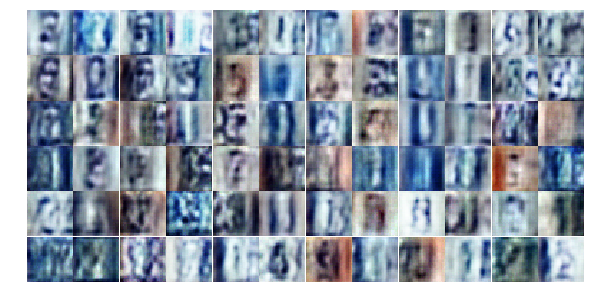

Epoch 3/25... Discriminator Loss: 0.9749... Generator Loss: 1.2520
Epoch 4/25... Discriminator Loss: 0.8068... Generator Loss: 1.3129
Epoch 4/25... Discriminator Loss: 0.8732... Generator Loss: 1.2626
Epoch 4/25... Discriminator Loss: 0.7153... Generator Loss: 1.3225
Epoch 4/25... Discriminator Loss: 0.8272... Generator Loss: 1.4707
Epoch 4/25... Discriminator Loss: 0.7040... Generator Loss: 1.1674
Epoch 4/25... Discriminator Loss: 0.9382... Generator Loss: 1.1150
Epoch 4/25... Discriminator Loss: 0.6790... Generator Loss: 1.3812
Epoch 4/25... Discriminator Loss: 0.6037... Generator Loss: 1.3786
Epoch 4/25... Discriminator Loss: 0.6129... Generator Loss: 1.3646


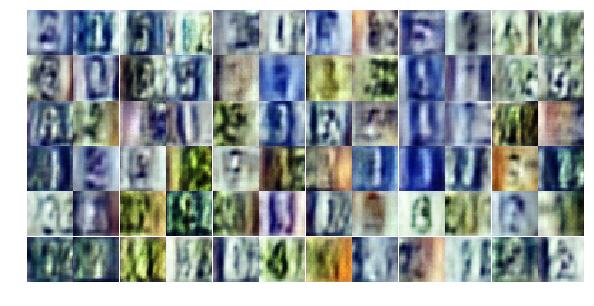

Epoch 4/25... Discriminator Loss: 0.6003... Generator Loss: 1.2717
Epoch 4/25... Discriminator Loss: 0.6635... Generator Loss: 1.3307
Epoch 4/25... Discriminator Loss: 0.9131... Generator Loss: 1.6012
Epoch 4/25... Discriminator Loss: 0.5885... Generator Loss: 1.4084
Epoch 4/25... Discriminator Loss: 0.8732... Generator Loss: 1.6304
Epoch 4/25... Discriminator Loss: 1.3545... Generator Loss: 0.4060
Epoch 4/25... Discriminator Loss: 0.9715... Generator Loss: 0.6767
Epoch 4/25... Discriminator Loss: 0.9179... Generator Loss: 0.7108
Epoch 4/25... Discriminator Loss: 1.2389... Generator Loss: 0.6125
Epoch 4/25... Discriminator Loss: 0.6416... Generator Loss: 1.7263


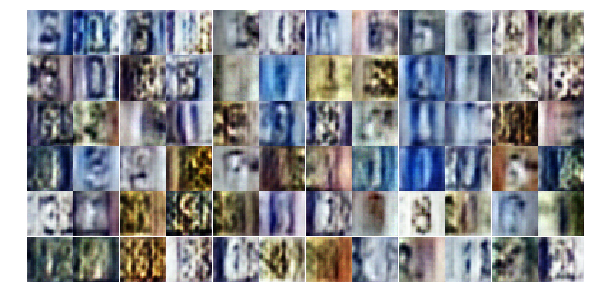

Epoch 4/25... Discriminator Loss: 0.6708... Generator Loss: 1.3274
Epoch 4/25... Discriminator Loss: 0.7097... Generator Loss: 1.2053
Epoch 4/25... Discriminator Loss: 0.8221... Generator Loss: 0.9602
Epoch 4/25... Discriminator Loss: 0.8369... Generator Loss: 0.8184
Epoch 4/25... Discriminator Loss: 0.4577... Generator Loss: 1.5813
Epoch 4/25... Discriminator Loss: 0.5745... Generator Loss: 2.2844
Epoch 4/25... Discriminator Loss: 0.8234... Generator Loss: 0.8764
Epoch 4/25... Discriminator Loss: 0.6296... Generator Loss: 1.1137
Epoch 4/25... Discriminator Loss: 0.6971... Generator Loss: 1.0447
Epoch 4/25... Discriminator Loss: 0.9630... Generator Loss: 1.9311


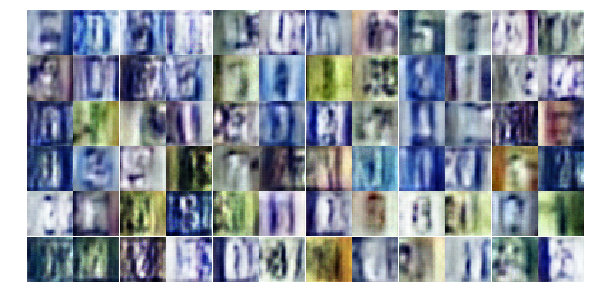

Epoch 4/25... Discriminator Loss: 0.6950... Generator Loss: 1.0896
Epoch 4/25... Discriminator Loss: 0.6496... Generator Loss: 1.3306
Epoch 4/25... Discriminator Loss: 0.6737... Generator Loss: 1.4917
Epoch 4/25... Discriminator Loss: 0.4879... Generator Loss: 1.7718
Epoch 4/25... Discriminator Loss: 0.5236... Generator Loss: 1.7247
Epoch 4/25... Discriminator Loss: 0.4096... Generator Loss: 1.8420
Epoch 4/25... Discriminator Loss: 0.7059... Generator Loss: 2.7373
Epoch 4/25... Discriminator Loss: 0.7295... Generator Loss: 1.1068
Epoch 4/25... Discriminator Loss: 0.5397... Generator Loss: 1.6730
Epoch 4/25... Discriminator Loss: 0.6940... Generator Loss: 1.0400


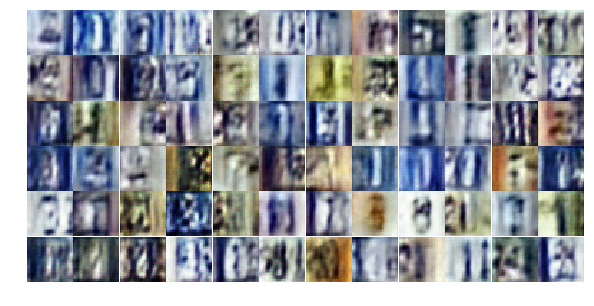

Epoch 4/25... Discriminator Loss: 0.7283... Generator Loss: 1.0774
Epoch 4/25... Discriminator Loss: 0.3402... Generator Loss: 1.7773
Epoch 4/25... Discriminator Loss: 0.6986... Generator Loss: 0.9031
Epoch 4/25... Discriminator Loss: 0.4020... Generator Loss: 2.2366
Epoch 4/25... Discriminator Loss: 0.4500... Generator Loss: 1.7762
Epoch 4/25... Discriminator Loss: 1.2320... Generator Loss: 2.4648
Epoch 4/25... Discriminator Loss: 0.9456... Generator Loss: 1.4023
Epoch 4/25... Discriminator Loss: 0.6671... Generator Loss: 1.3878
Epoch 4/25... Discriminator Loss: 0.5935... Generator Loss: 1.2134
Epoch 4/25... Discriminator Loss: 0.3475... Generator Loss: 2.4291


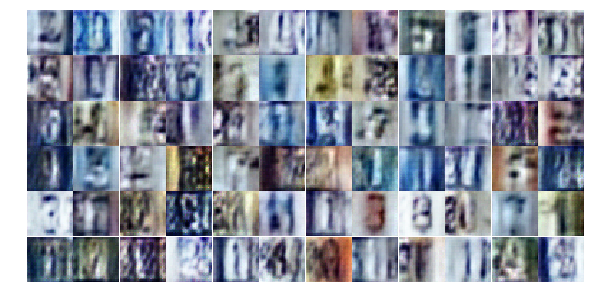

Epoch 4/25... Discriminator Loss: 0.3251... Generator Loss: 2.1914
Epoch 4/25... Discriminator Loss: 0.4582... Generator Loss: 2.0043
Epoch 4/25... Discriminator Loss: 0.2955... Generator Loss: 2.4989
Epoch 4/25... Discriminator Loss: 0.9816... Generator Loss: 3.3463
Epoch 4/25... Discriminator Loss: 0.7575... Generator Loss: 0.9352
Epoch 4/25... Discriminator Loss: 0.5745... Generator Loss: 1.3047
Epoch 4/25... Discriminator Loss: 0.5432... Generator Loss: 1.2169
Epoch 4/25... Discriminator Loss: 0.5771... Generator Loss: 1.1664
Epoch 4/25... Discriminator Loss: 0.4862... Generator Loss: 1.6637
Epoch 5/25... Discriminator Loss: 0.7909... Generator Loss: 2.3692


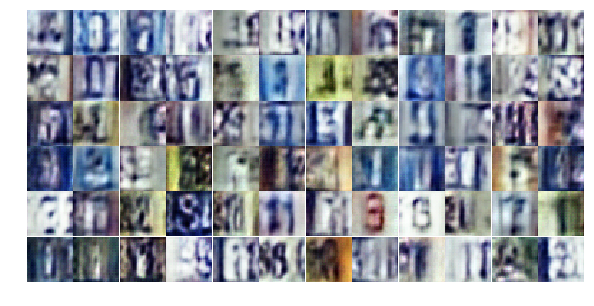

Epoch 5/25... Discriminator Loss: 0.4256... Generator Loss: 1.7843
Epoch 5/25... Discriminator Loss: 0.5072... Generator Loss: 1.3573
Epoch 5/25... Discriminator Loss: 0.7396... Generator Loss: 0.9505
Epoch 5/25... Discriminator Loss: 0.4108... Generator Loss: 1.4767
Epoch 5/25... Discriminator Loss: 0.7079... Generator Loss: 2.5692
Epoch 5/25... Discriminator Loss: 0.7968... Generator Loss: 0.9906
Epoch 5/25... Discriminator Loss: 0.3903... Generator Loss: 1.6332
Epoch 5/25... Discriminator Loss: 0.6060... Generator Loss: 1.0886
Epoch 5/25... Discriminator Loss: 0.5845... Generator Loss: 1.1317
Epoch 5/25... Discriminator Loss: 0.7781... Generator Loss: 0.8640


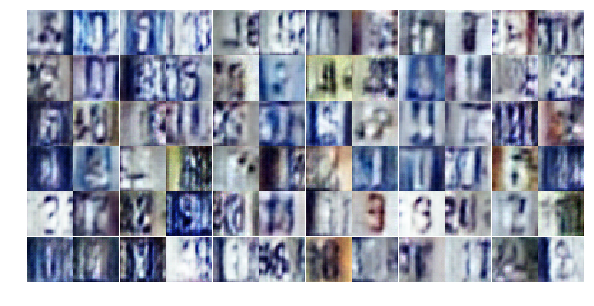

Epoch 5/25... Discriminator Loss: 0.8371... Generator Loss: 3.0659
Epoch 5/25... Discriminator Loss: 1.1578... Generator Loss: 0.8438
Epoch 5/25... Discriminator Loss: 0.3881... Generator Loss: 2.1911
Epoch 5/25... Discriminator Loss: 1.3777... Generator Loss: 0.4279
Epoch 5/25... Discriminator Loss: 1.0652... Generator Loss: 1.8864
Epoch 5/25... Discriminator Loss: 1.1597... Generator Loss: 0.5795
Epoch 5/25... Discriminator Loss: 0.6340... Generator Loss: 1.2004
Epoch 5/25... Discriminator Loss: 0.3860... Generator Loss: 1.9305
Epoch 5/25... Discriminator Loss: 0.4361... Generator Loss: 2.1847
Epoch 5/25... Discriminator Loss: 0.4261... Generator Loss: 1.8212


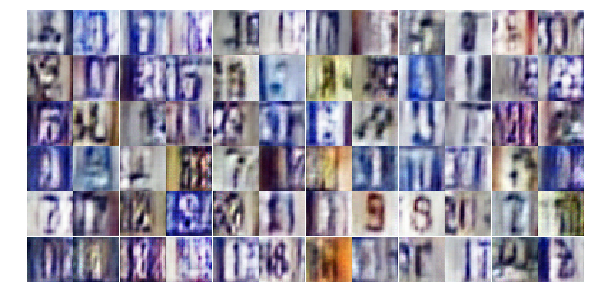

Epoch 5/25... Discriminator Loss: 0.3919... Generator Loss: 1.8958
Epoch 5/25... Discriminator Loss: 0.8407... Generator Loss: 0.7421
Epoch 5/25... Discriminator Loss: 0.5212... Generator Loss: 1.5276
Epoch 5/25... Discriminator Loss: 0.5766... Generator Loss: 1.5215
Epoch 5/25... Discriminator Loss: 0.8108... Generator Loss: 0.8099
Epoch 5/25... Discriminator Loss: 0.5812... Generator Loss: 1.1710
Epoch 5/25... Discriminator Loss: 0.6528... Generator Loss: 1.0974
Epoch 5/25... Discriminator Loss: 2.2334... Generator Loss: 0.2200
Epoch 5/25... Discriminator Loss: 0.6193... Generator Loss: 1.6450
Epoch 5/25... Discriminator Loss: 0.5177... Generator Loss: 1.3401


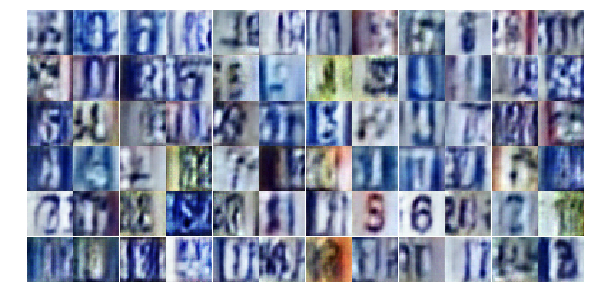

Epoch 5/25... Discriminator Loss: 0.7307... Generator Loss: 1.4812
Epoch 5/25... Discriminator Loss: 0.3855... Generator Loss: 1.6517
Epoch 5/25... Discriminator Loss: 0.4861... Generator Loss: 2.1679
Epoch 5/25... Discriminator Loss: 0.5449... Generator Loss: 1.5929
Epoch 5/25... Discriminator Loss: 0.5330... Generator Loss: 1.5965
Epoch 5/25... Discriminator Loss: 0.6138... Generator Loss: 2.3550
Epoch 5/25... Discriminator Loss: 0.8704... Generator Loss: 1.1600
Epoch 5/25... Discriminator Loss: 0.7710... Generator Loss: 0.8800
Epoch 5/25... Discriminator Loss: 0.8000... Generator Loss: 0.9032
Epoch 5/25... Discriminator Loss: 0.6378... Generator Loss: 1.0671


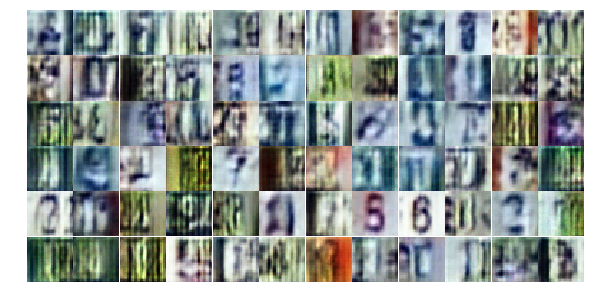

Epoch 5/25... Discriminator Loss: 0.3895... Generator Loss: 1.6884
Epoch 5/25... Discriminator Loss: 0.7333... Generator Loss: 0.9357
Epoch 5/25... Discriminator Loss: 1.4493... Generator Loss: 0.4886
Epoch 5/25... Discriminator Loss: 1.0916... Generator Loss: 0.7023
Epoch 5/25... Discriminator Loss: 0.9193... Generator Loss: 0.7854
Epoch 5/25... Discriminator Loss: 0.9416... Generator Loss: 0.7254
Epoch 5/25... Discriminator Loss: 0.5552... Generator Loss: 1.5794
Epoch 5/25... Discriminator Loss: 0.6784... Generator Loss: 1.1311
Epoch 5/25... Discriminator Loss: 0.7171... Generator Loss: 1.2412
Epoch 5/25... Discriminator Loss: 0.5592... Generator Loss: 1.3524


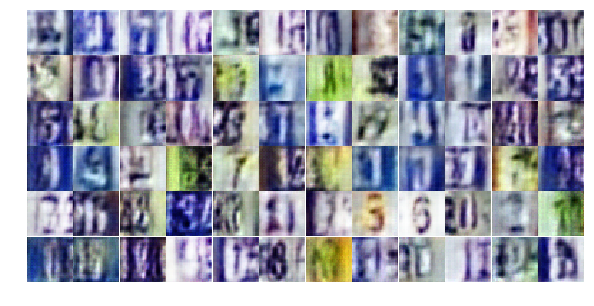

Epoch 5/25... Discriminator Loss: 0.8821... Generator Loss: 0.7045
Epoch 5/25... Discriminator Loss: 0.4935... Generator Loss: 1.3987
Epoch 5/25... Discriminator Loss: 0.7739... Generator Loss: 1.1917
Epoch 5/25... Discriminator Loss: 0.5886... Generator Loss: 1.2010
Epoch 5/25... Discriminator Loss: 0.5837... Generator Loss: 1.2280
Epoch 5/25... Discriminator Loss: 0.7890... Generator Loss: 2.0426
Epoch 6/25... Discriminator Loss: 1.3270... Generator Loss: 0.4379
Epoch 6/25... Discriminator Loss: 0.5840... Generator Loss: 1.3018
Epoch 6/25... Discriminator Loss: 0.7474... Generator Loss: 0.8986
Epoch 6/25... Discriminator Loss: 0.7313... Generator Loss: 0.9541


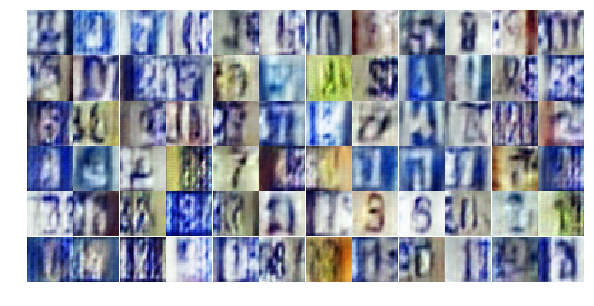

Epoch 6/25... Discriminator Loss: 0.7775... Generator Loss: 0.8535
Epoch 6/25... Discriminator Loss: 0.6114... Generator Loss: 1.1689
Epoch 6/25... Discriminator Loss: 0.6076... Generator Loss: 1.4904
Epoch 6/25... Discriminator Loss: 0.6621... Generator Loss: 1.5003
Epoch 6/25... Discriminator Loss: 0.9091... Generator Loss: 0.6994
Epoch 6/25... Discriminator Loss: 0.5771... Generator Loss: 1.0897
Epoch 6/25... Discriminator Loss: 0.3647... Generator Loss: 1.6846
Epoch 6/25... Discriminator Loss: 1.1361... Generator Loss: 1.5862
Epoch 6/25... Discriminator Loss: 0.8197... Generator Loss: 0.8107
Epoch 6/25... Discriminator Loss: 0.7027... Generator Loss: 2.4926


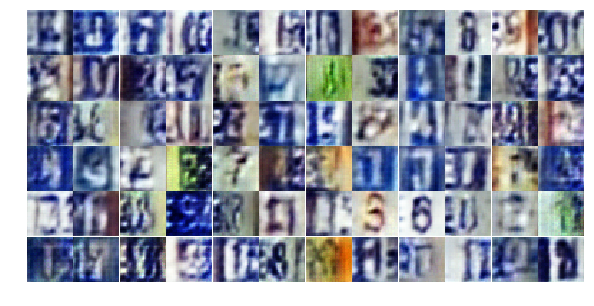

Epoch 6/25... Discriminator Loss: 0.6864... Generator Loss: 1.1582
Epoch 6/25... Discriminator Loss: 0.7478... Generator Loss: 1.0890


KeyboardInterrupt: 

In [28]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))